In [3]:
import sys
print(sys.version) # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [4]:
import tensorflow as tf

tf.enable_eager_execution()

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

from itertools import combinations, combinations_with_replacement

In [6]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

df = pd.read_csv('/data/fp_ica16.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,50540.000,25269.500,14589.786,0.000,12634.750,25269.500,37904.250,50539.000
true_year,50540.000,0.701,0.169,0.000,0.580,0.720,0.820,1.000
prediction,50540.000,0.711,0.133,0.178,0.611,0.735,0.817,0.960
row,50540.000,25269.500,14589.786,0.000,12634.750,25269.500,37904.250,50539.000
factor0,50540.000,-0.000,1.000,-8.903,-0.395,-0.117,0.165,22.707
factor1,50540.000,0.000,1.000,-9.093,-0.509,0.049,0.585,8.094
factor2,50540.000,-0.000,1.000,-7.633,-0.746,0.078,0.788,6.049
factor3,50540.000,-0.000,1.000,-14.426,-0.523,0.054,0.560,33.931
factor4,50540.000,0.000,1.000,-16.706,-0.473,0.015,0.482,7.154
factor5,50540.000,-0.000,1.000,-73.539,-0.296,0.026,0.360,10.851


In [7]:
BATCH_SIZE = 8

def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [8]:
predict_dataset =  create_predict_dataset(
    ["/data/fp_train.tfrecord",
     "/data/fp_test.tfrecord"])
iter = predict_dataset.make_one_shot_iterator()

fps = []
for batch in iter:
    fps.extend(batch[0].numpy())

len(fps), fps[0][:,:,0].shape

Instructions for updating:
Colocations handled automatically by placer.


(50540, (28, 28))

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]
(28, 28, 6)
(50540, 28, 28, 4)
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


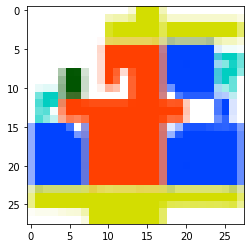

In [9]:
# adjusted for different luminance
channel_to_rgba = np.array(
    [[0., 0., 0., 1.], # unit mask to alpha
     [0., 0.33, 0., 0.], # entrance to green L30
     [1., 0.25, 0., 0.], # LDK to red L57
     [0., 0.26, 1., 0.], # bedroom to blue L40
     [0.83, 0.87, 0., 0.], # balcony to yellow L85
     [0., 0.81, 0.76, 0.]]) # bathroom to cyan L75

# make colors subtractive
channel_to_rgba[1:6, 0:3] -= 1

print(channel_to_rgba)
print(fps[0].shape)

# put it on transparent white
fps_rgba = np.array([1.,1.,1.,0.])+(np.array(fps) @ channel_to_rgba)
print(fps_rgba.shape)

np.set_printoptions(suppress=True)
print(np.amin(fps_rgba, axis=(1,2,3)))
print(np.amax(fps_rgba, axis=(1,2,3)))
fps_rgba = np.clip(fps_rgba, 0, 1)

fig = plt.figure()
ax = plt.imshow(fps_rgba[5])

In [10]:
df['weight'] = df.N_Units.clip(1, ) # at least 1 unit exists

sigma = [[-10, 10]] * 16

n_factors = 16
n_bins, n_samples = 40, 10
N = n_bins * n_samples

for f in range(n_factors):
    bin_f = 'bin{}'.format(f)
    df[bin_f] = pd.cut(df['factor{}'.format(f)].clip(*sigma[f]), n_bins, labels=False)

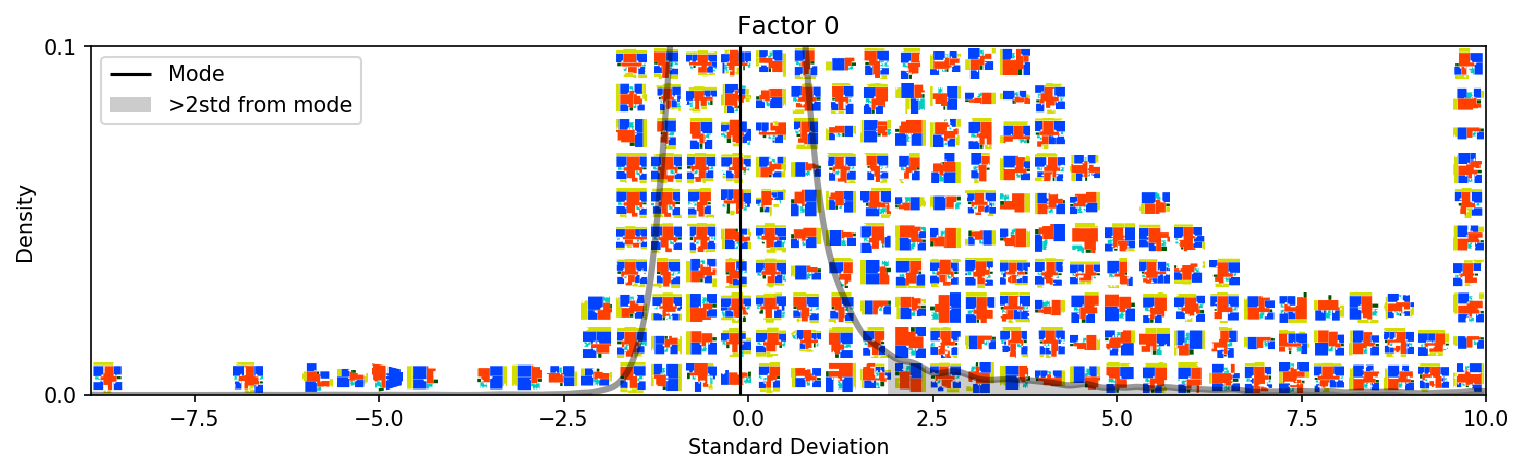

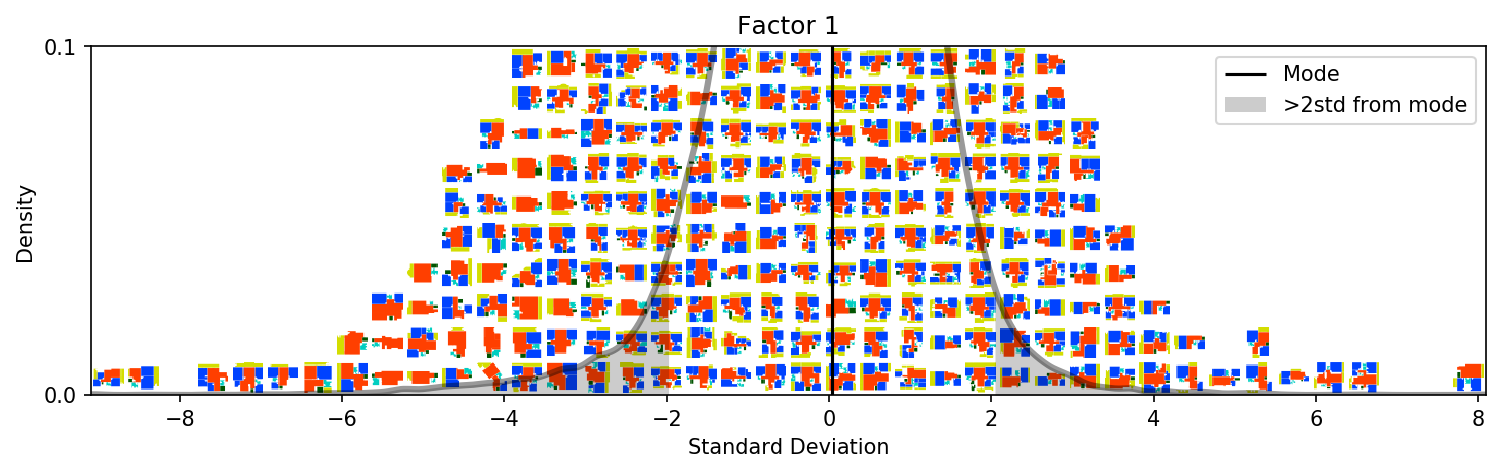

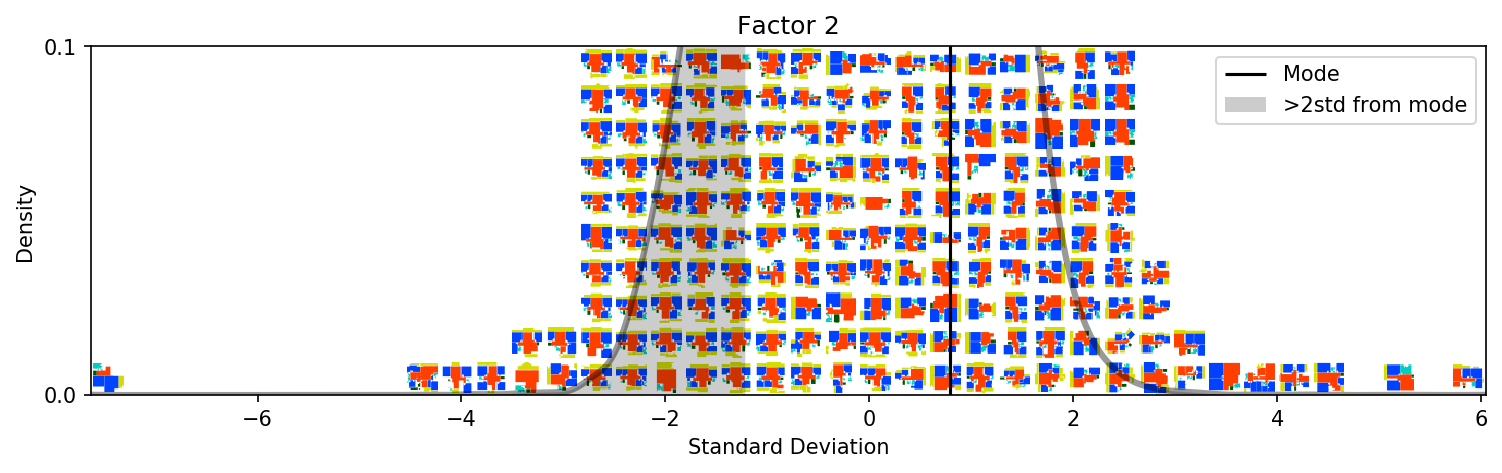

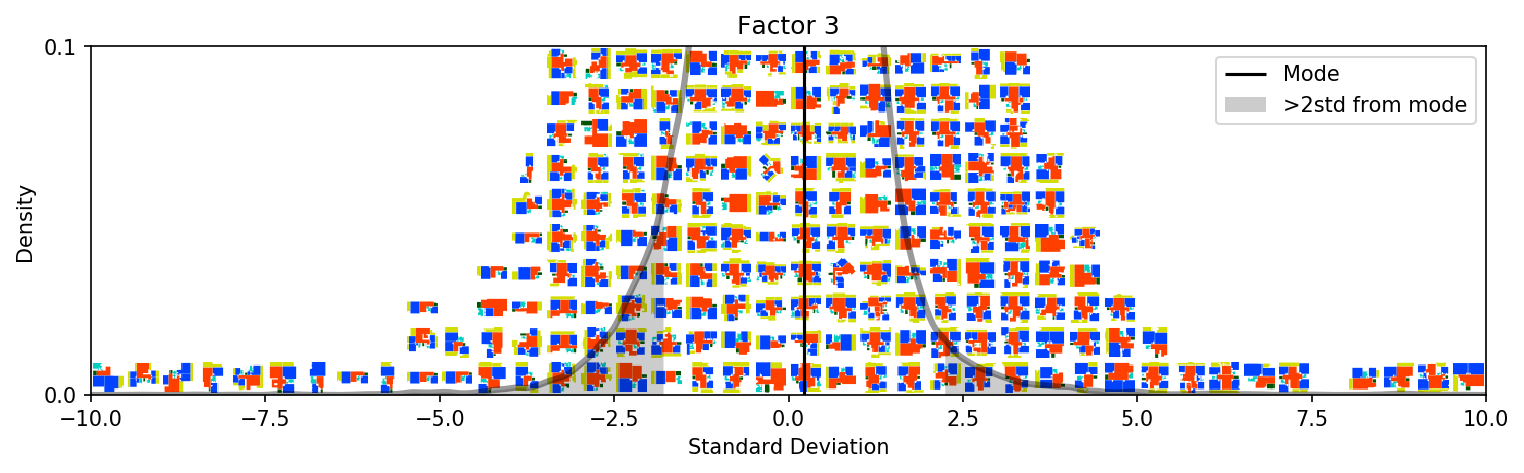

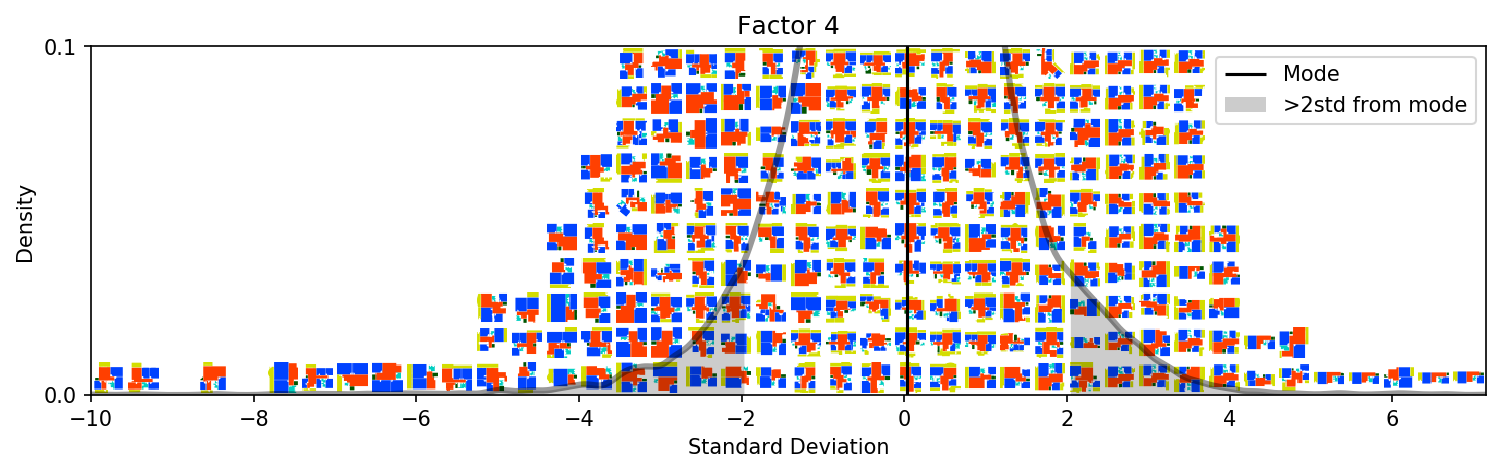

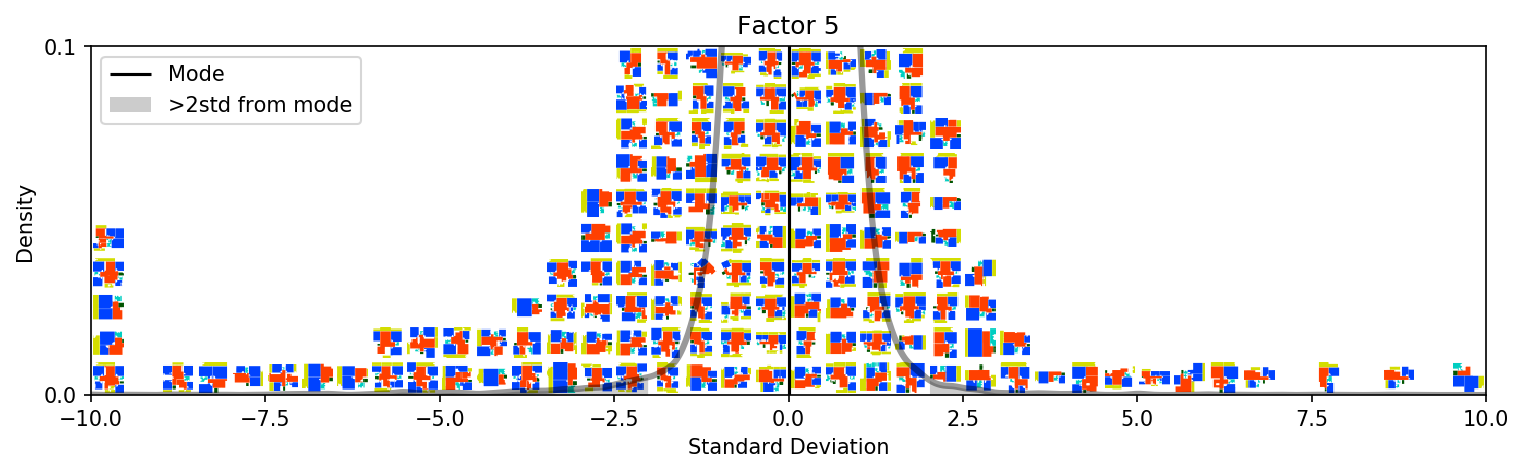

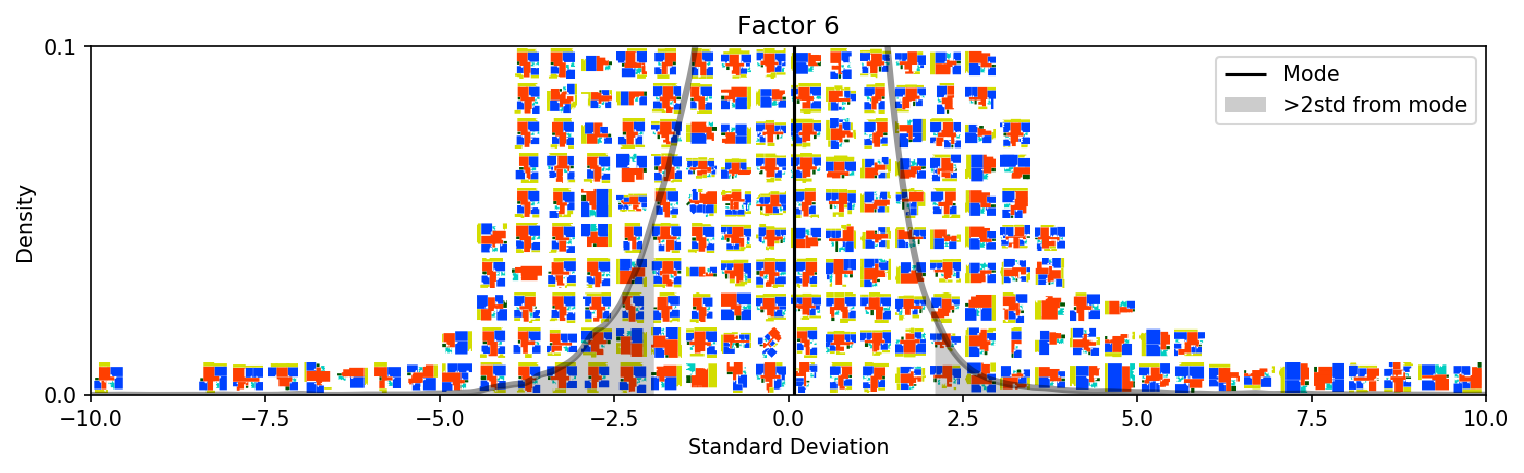

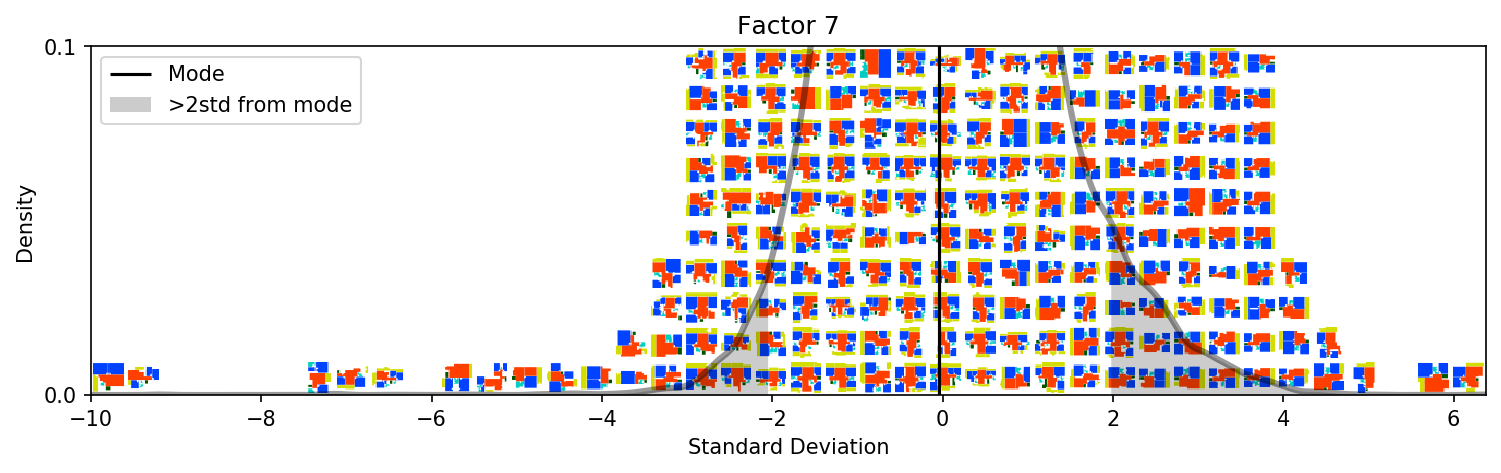

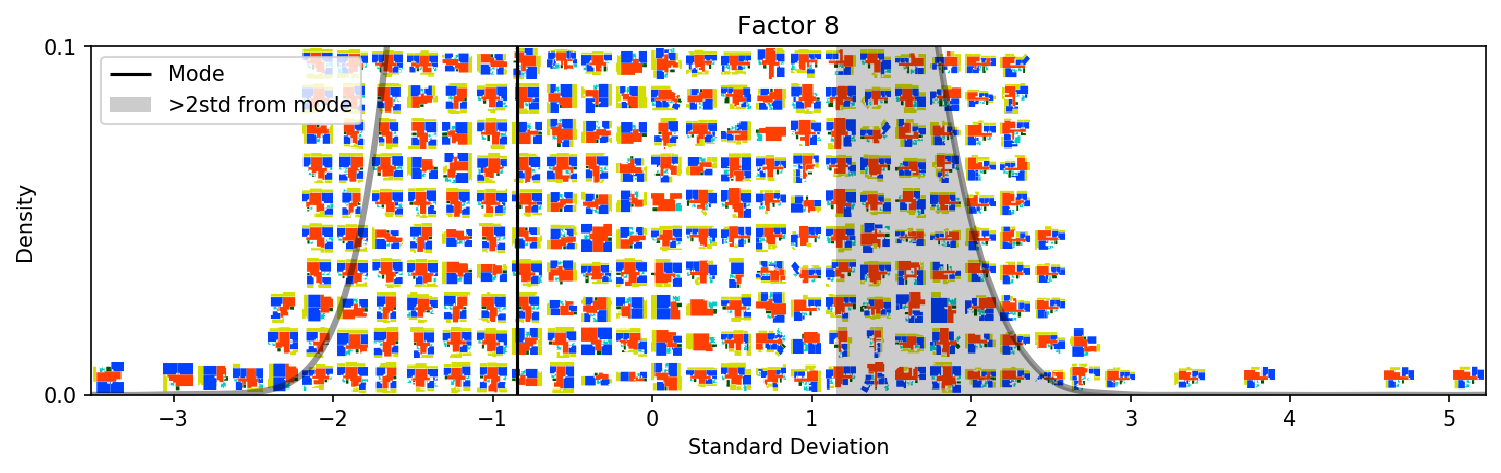

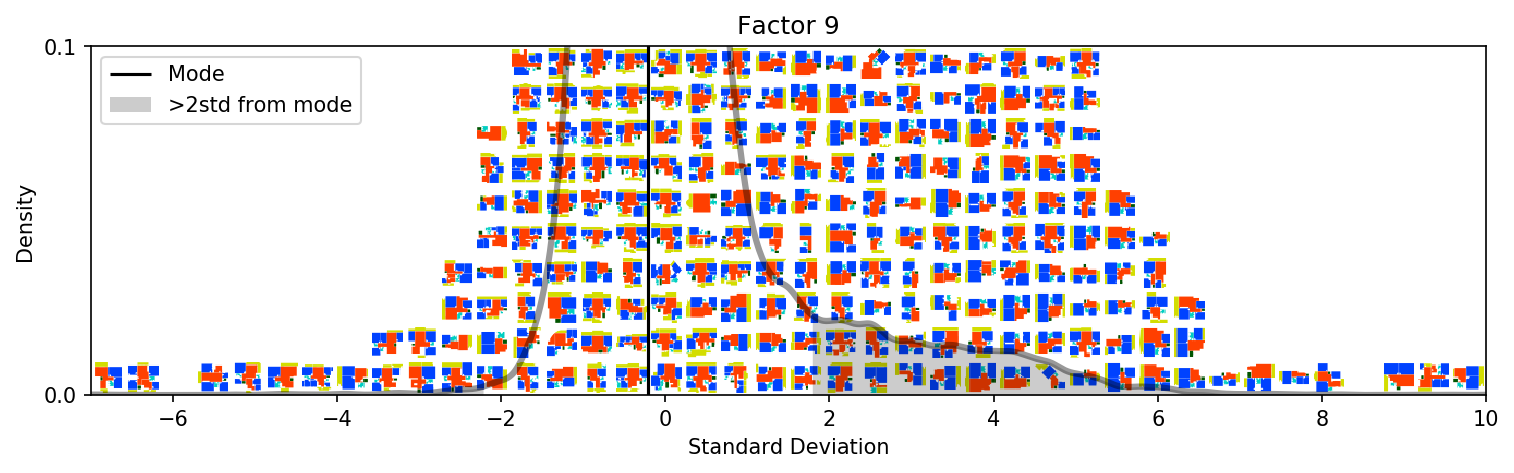

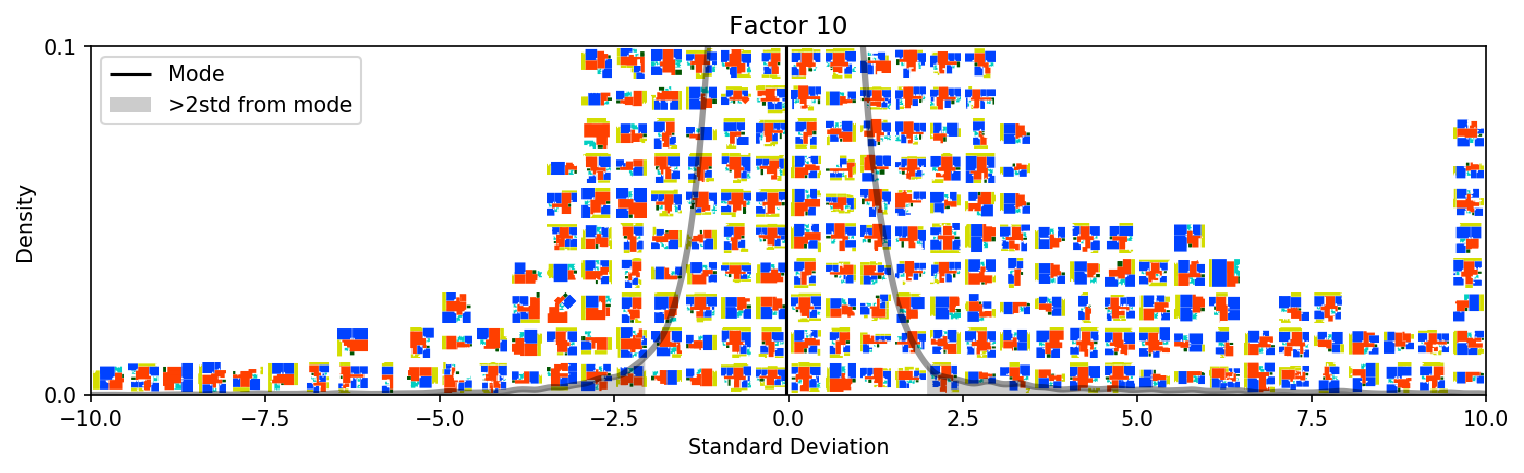

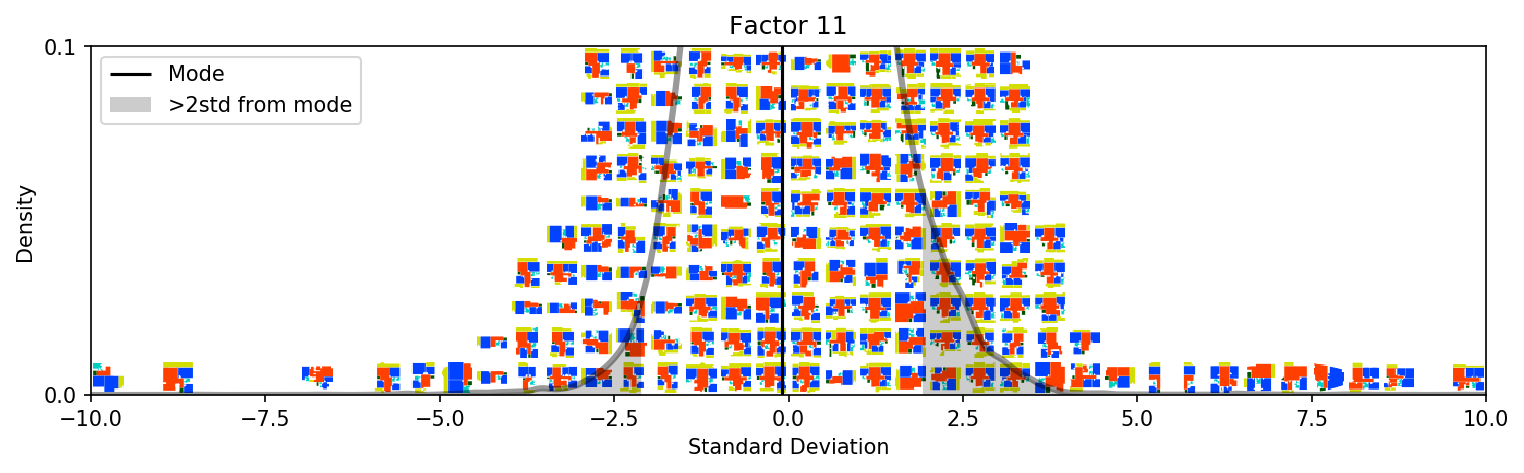

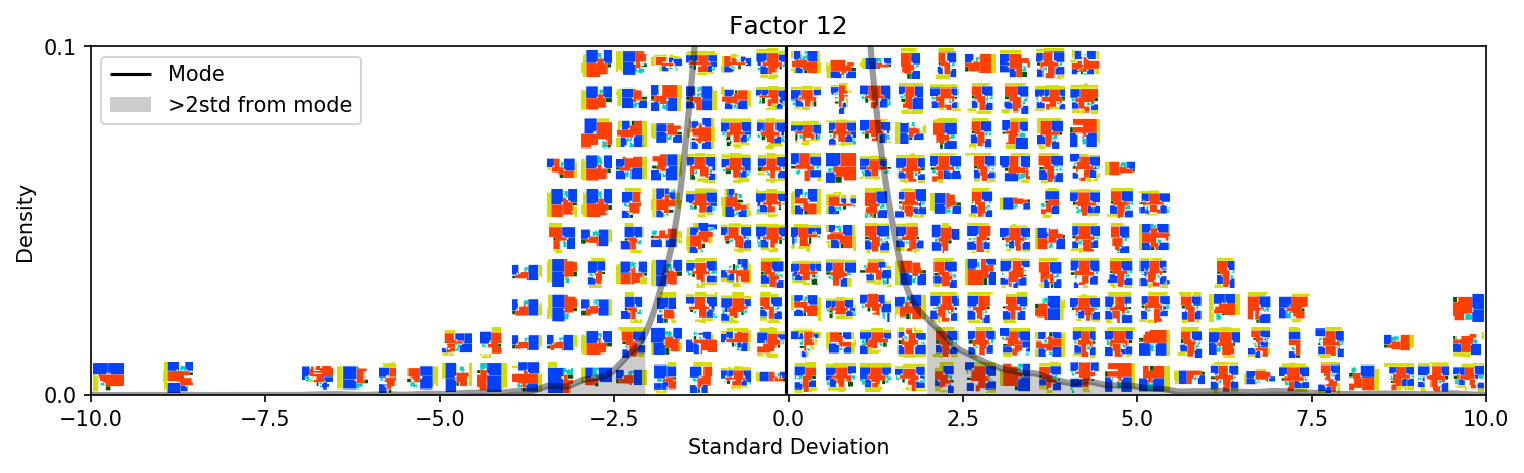

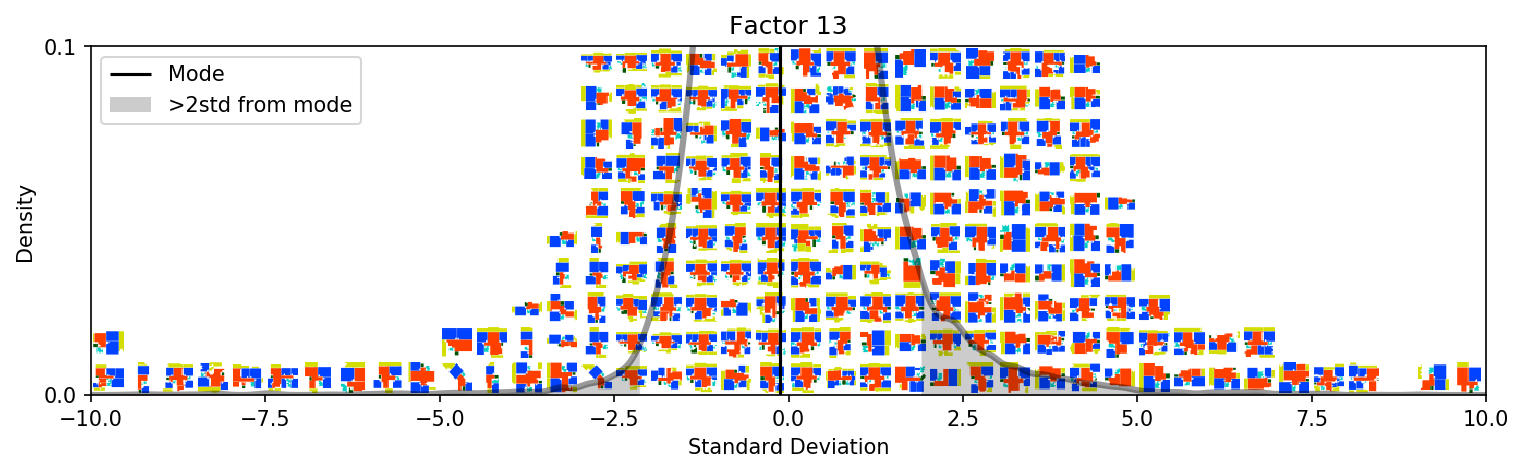

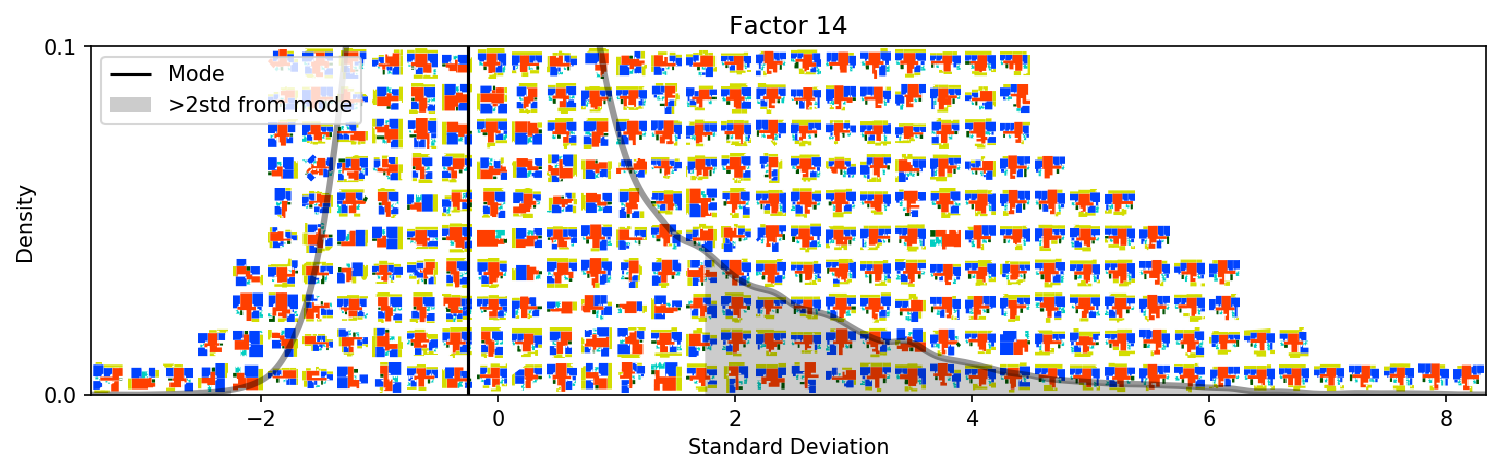

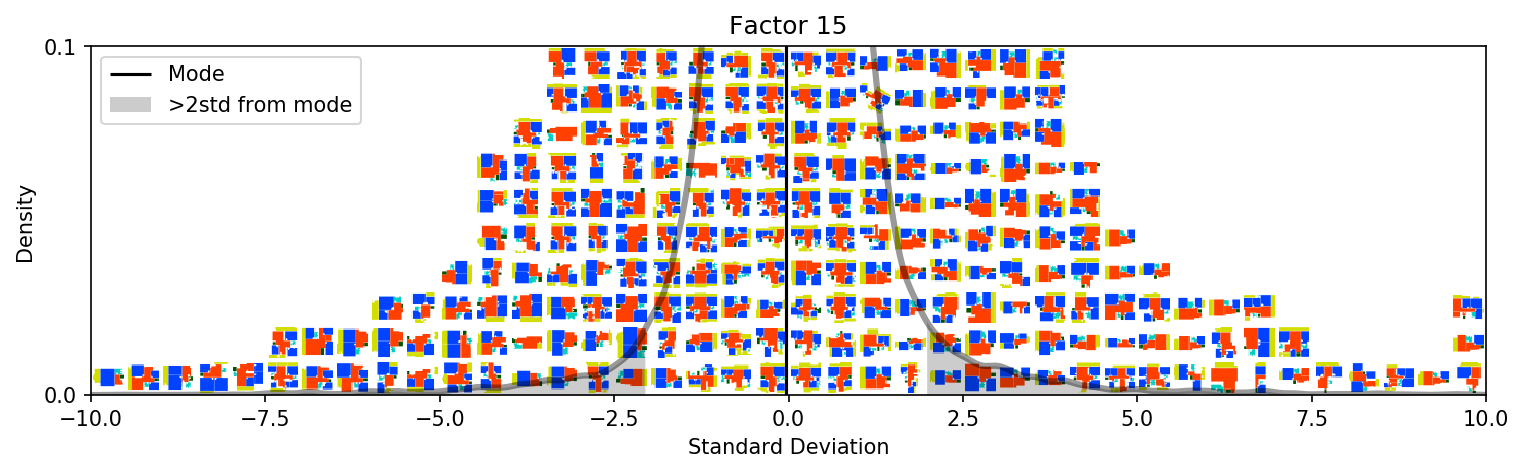

In [12]:
# stratified sample by standard deviation

border = 2
interval = 28 + border*2

fp_map = np.zeros((n_factors, n_samples*interval, n_bins*interval, 4)) # rc coord

# sample = df.sample(N, weights='weight', random_state=1106)

for f in range(n_factors):
    bin_f = 'bin{}'.format(f)
    
    for c in range(n_bins):
        df_bin = df[df[bin_f] == c]
        
        if len(df_bin):
            sample = df_bin.sample(min(len(df_bin)//10 + 1, n_samples), weights='weight', random_state=1106)
            rows = sample.sort_values(by='factor{}'.format(f)).row

            for r in range(len(rows)):
                row = rows.iat[r]
                fp_map[f, 
                       r*interval+border:(r+1)*interval-border, 
                       c*interval+border:(c+1)*interval-border, 
                       :] = fps_rgba[row]

# fig, axs = plt.subplots(n_factors, 1, figsize=(36, 36))
for f in range(n_factors):
    fig = plt.figure(figsize=(12, 12), dpi=150)

    df_clipped = df['factor{}'.format(f)].clip(*sigma[f])
    xlim = [df_clipped.min(), df_clipped.max()]
    
    ax = fig.gca()
    
    kernel = gaussian_kde(df['factor{}'.format(f)])
    xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
    ys = kernel(xs)
    ax.plot(xs, ys, color='k', linewidth=3, alpha=0.4)

    x_mode = xs[np.argmax(ys)]
    line_mode = ax.vlines(x_mode, 0, ys.max(), color='k')
    
    x_left_tail, x_right_tail = xs.searchsorted(x_mode-2), xs.searchsorted(x_mode+2)
    xs_left, xs_right = xs[0:x_left_tail], xs[x_right_tail:-1]
    ys_left, ys_right = ys[0:x_left_tail], ys[x_right_tail:-1]

    poly_tail = ax.fill_between(xs_left, ys_left, color='k', linewidth=0, alpha=0.2)
    ax.fill_between(xs_right, ys_right, color='k', linewidth=0, alpha=0.2)
    
#     ymax = ys.mean()
#     ymax = np.median(ys)
#     ymax = 1 / (xlim[1]-xlim[0])
    ymax = 0.1
#     ymax = max([a.max() for a in [ys_left, ys_right] if a.any()]) *2
    ax.imshow(fp_map[f], aspect=((xlim[1]-xlim[0])/ymax)/(n_bins/n_samples), 
              origin='lower', extent=[*xlim, 0., ymax], zorder=0)

    is_right_tail = x_mode <= 0 # True if positive skew
    loc_legend = 2 if is_right_tail else 1 # upper left if right tail and vice versa
    ax.legend((line_mode, poly_tail), ('Mode', '>2std from mode'), loc=loc_legend)

    ax.set_title('Factor {}'.format(f))
    ax.set_yticks(ax.get_ylim())
    ax.set_ylabel('Density')
#     ax.set_ylim((0, ymax))
    
#     ax.set_xticks(list(ax.get_xticks())+[x_mode])
#     ax.set_xlim(xlim)

    ax.set_xlabel('Standard Deviation')
    
    plt.show()


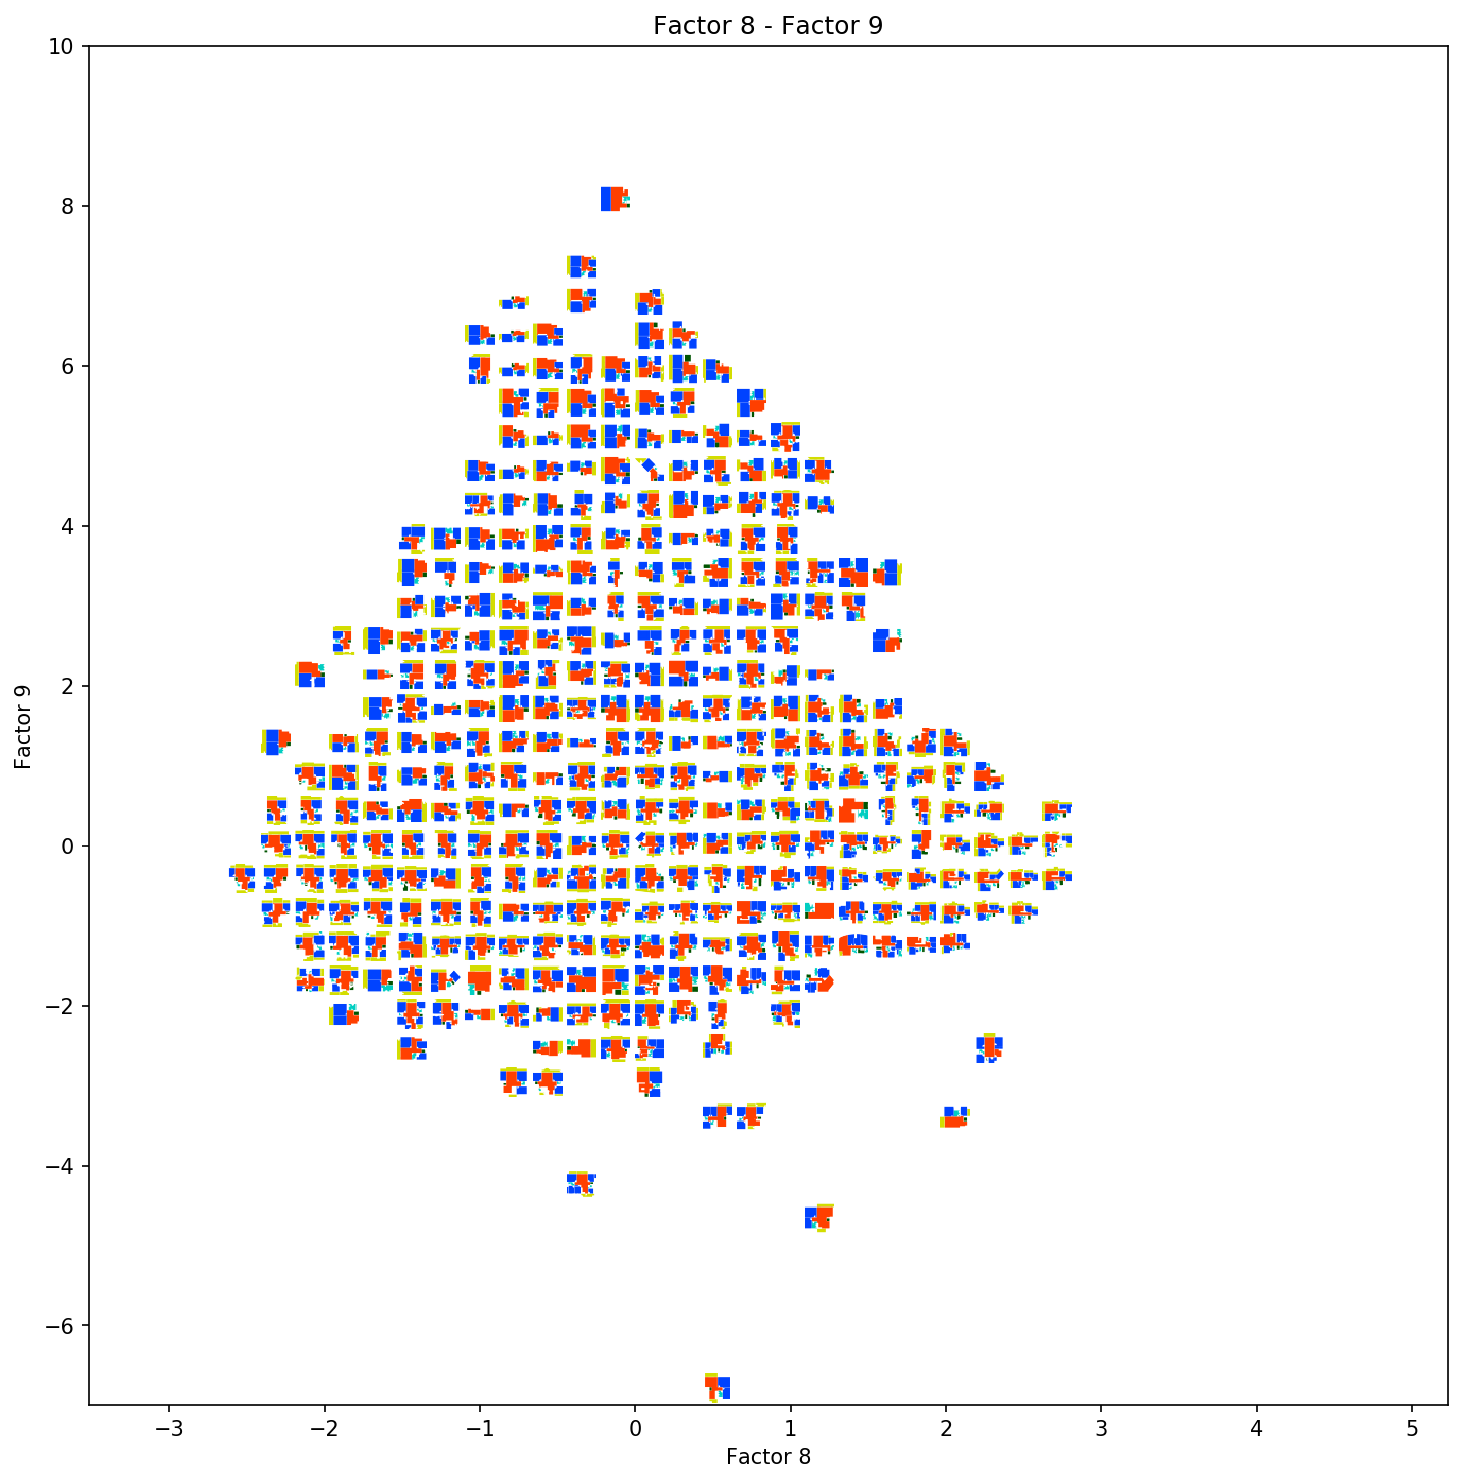

In [13]:
# 2D stratified sample by two factors

border = 2
interval = 28 + border*2

fp_map2d = np.zeros((n_bins*interval, n_bins*interval, 4))
fc = 8
fr=9
bin_fc, bin_fr = ['bin{}'.format(f) for f in [fc, fr]]
    
for c in range(n_bins):
    for r in range(n_bins):
        df_bin = df[(df[bin_fc] == c) & (df[bin_fr] == r)]

        if len(df_bin)>=2: # expects 2*2500/50000 = 1/10 likelihood
            sample = df_bin.sample(1, weights='weight', random_state=1106)
            row = sample.row.iat[0]

            fp_map2d[
                     r*interval+border:(r+1)*interval-border, 
                     c*interval+border:(c+1)*interval-border, 
                ] = fps_rgba[row]


df_clipped_x, df_clipped_y = [df['factor{}'.format(f)].clip(*sigma[f]) 
                              for f in [fc, fr]]
xlim, ylim = [[df_clipped.min(), df_clipped.max()]
              for df_clipped in [df_clipped_x, df_clipped_y]]

fig = plt.figure(figsize=(12, 12), dpi=150)
ax = fig.gca()

ax.imshow(fp_map2d, aspect=((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))/(n_bins/n_bins), 
          origin='lower', extent=[*xlim, *ylim], zorder=0)

ax.set_title('Factor {} - Factor {}'.format(fc, fr))
ax.set_xlabel('Factor {}'.format(fc))
ax.set_ylabel('Factor {}'.format(fr))

plt.show()